In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_rows, img_cols, img_chns = 28, 28, 1
original_img_size = (img_rows, img_cols, img_chns)
batch_size = 256
epochs = 1000
learning_rate = 0.0005
dropout = 0.1

# 8000太大了，内存不够，设置成一半
hidden_units = 4000
hidden_layers = 2

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

X_train = np.round(X_train.reshape(X_train.shape[0], img_rows * img_cols) / 255.)
X_test = np.round(X_test.reshape(X_test.shape[0], img_rows * img_cols) / 255.)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [4]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.repeat().batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [5]:
from tensorflow.keras import initializers
from tensorflow.keras import activations
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

class MaskingDense(tf.keras.layers.Layer):
    # 自定义的层，从keras Dense layer修改而来
    """
    Arguments:
    units: Positive integer, dimensionality of the output space.
    activation: Activation function to use.
      If you don't specify anything, no activation is applied
      (ie. "linear" activation: `a(x) = x`).
    use_bias: Boolean, whether the layer uses a bias vector.
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    kernel_regularizer: Regularizer function applied to the `kernel` weights matrix.
    bias_regularizer: Regularizer function applied to the bias vector.
    activity_regularizer: Regularizer function applied to
      the output of the layer (its "activation")..
    kernel_constraint: Constraint function applied to
      the `kernel` weights matrix.
    bias_constraint: Constraint function applied to the bias vector.
    """
    def __init__(self, units, out_units,
                 hidden_layers=1,
                 dropout_rate=0.0,
                 random_input_order=False,
                 activation='relu',
                 out_activation='sigmoid',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(MaskingDense, self).__init__(**kwargs)
        
        self.input_sel = None
        self.random_input_order = random_input_order
        self.rate = min(1., max(0., dropout_rate))
        self.kernel_sels = []
        self.units = units
        self.out_units = out_units
        self.hidden_layers = hidden_layers
        self.activation = activations.get(activation)
        self.out_activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        
    def dropout_wrapper(self, inputs, training):
        if 0. < self.rate < 1.:
            def dropped_inputs():
                return tf.keras.backend.dropout(inputs, self.rate, noise_shape=None, seed=None)
            return tf.keras.backend.in_train_phase(dropped_inputs, inputs,
                                    training=training)
        
        return inputs    
    
    def build_layer_weights(self, input_dim, units, use_bias=True):
        # 创建 kernel 和 bias
        kernel = self.add_weight(shape=(input_dim, units),
                                 initializer=self.kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)
     
        if use_bias:
            bias = self.add_weight(shape=(units,),
                                   initializer=self.bias_initializer,
                                   name='bias',
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        else:
            bias = None
        
        return kernel, bias    
        
    def build_mask(self, shape, prev_sel, is_output):
        if is_output:
            # 最终输出的sel一定要包含全部的初始sel
            input_sel = self.input_sel
        else:
            # Disallow D-1 because it would violate auto-regressive property
            # Disallow 0 because it would just createa a constant node
            # Disallow unconnected units by sampling min from previous layer
            input_sel = [np.random.randint(np.min(prev_sel), shape[-1] - 2) for i in range(shape[-1])]
            # eg，shape = 256*784, prev_sel是0-783，则input_sel是从 prev_sel最小值到784-2的随机数，有重复，但是一般端点都在里面
            # 后层的元代表的多少号变量，是随机的。但是总是>=前层的最小变量，上不封顶
            
        def vals():
            for x in range(shape[-2]):
                for y in range(shape[-1]):
                    if is_output:
                        # 输出的时候，不能依赖自身，所以是<。eg，0号变量，不能依赖任何元
                        yield 1 if prev_sel[x] < input_sel[y] else 0
                    else:
                        # 小的才能传递给大的。前层的x号元代表的prev_sel[x]号变量，如小于后层的y号元，则mask = 1
                        yield 1 if prev_sel[x] <= input_sel[y] else 0
        
        # 假设shape是784，128.这里输出，在内循环是输出了128个，重复了784次，所以reshape后形状和要求的一样，并且和weight的顺序也匹配
        return tf.keras.backend.constant(list(vals()), dtype='float32', shape=shape), input_sel
        
    def build(self, input_shape):
        print(input_shape)
        assert len(input_shape) >= 2
           
        self.kernels, self.biases = [], []
        self.kernel_masks, self.kernel_sels = [], []
        shape = (input_shape[-1], self.units)
        
        print(input_shape)
        # 这个是全局的input_sel
        self.input_sel = np.arange(input_shape[-1])
        if self.random_input_order:
            np.random.shuffle(self.input_sel)
        prev_sel = self.input_sel
        
        # 如果要masking，肯定不止一层，具体情况根据输入形状来定，越大的应该越深
        for x in range(self.hidden_layers):
            # Hidden layer
            kernel, bias = self.build_layer_weights(*shape)
            self.kernels.append(kernel)
            self.biases.append(bias)
            
            # Hidden layer mask
            kernel_mask, kernel_sel = self.build_mask(shape, prev_sel, is_output=False)
            self.kernel_masks.append(kernel_mask)
            self.kernel_sels.append(kernel_sel)
            
            # 将随机出来的sel作为下次的prev_sel。
            prev_sel = kernel_sel
            shape = (self.units, self.units)

        # Direct connection between input/output。在MADE里提出的，类似residual的方法
        direct_shape = (input_shape[-1], self.out_units)
        self.direct_kernel, _ = self.build_layer_weights(*direct_shape, use_bias=False)
        self.direct_kernel_mask, self.direct_sel = self.build_mask(direct_shape, self.input_sel, is_output=True)
        
        # Output layer
        out_shape = (self.units, self.out_units)
        self.out_kernel, self.out_bias = self.build_layer_weights(*out_shape)
        self.out_kernel_mask, self.out_sel = self.build_mask(out_shape, prev_sel, is_output=True)
        
        self.built = True

    def call(self, inputs, training=None):
        # Hidden layer + mask
        output = inputs
        for i in range(self.hidden_layers):
            # kernel和mask等大小，进行数乘
            weight = self.kernels[i] * self.kernel_masks[i]
            output = tf.keras.backend.dot(output, weight)
            output = tf.keras.backend.bias_add(output, self.biases[i])
            output = self.activation(output)
            output = self.dropout_wrapper(output, training)
       
        # Direct connection
        direct = tf.keras.backend.dot(inputs, self.direct_kernel * self.direct_kernel_mask)
        direct = self.dropout_wrapper(direct, training)
        
        # out_act(bias + (V dot M_v)h(x) + (A dot M_v)x) 因为output层是专门提出循环的，所以最后要单独再来一次
        output = tf.keras.backend.dot(output, self.out_kernel * self.out_kernel_mask)
        output = output + direct
        output = tf.keras.backend.bias_add(output, self.out_bias)
        output = self.out_activation(output)
        
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.out_units)

In [6]:
def logx_loss(x, x_decoded_mean):
    x = tf.keras.backend.flatten(x)
    x_decoded_mean =tf.keras.backend.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * tf.keras.metrics.binary_crossentropy(x, x_decoded_mean)
    return xent_loss

In [7]:
class MADE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.masking = MaskingDense(hidden_units, img_rows * img_cols, 
                      hidden_layers=hidden_layers,
                      dropout_rate=dropout,
                      random_input_order=False)
    
    def call(self, inputs):
        output = self.masking(inputs)
        return output

In [8]:
made = MADE()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
training_steps = 1000

for step, (x, _) in enumerate(train_data.take(training_steps + 1)):
    with tf.GradientTape() as g:
        y_pred = made(x)
        loss = logx_loss(x, y_pred)
        
        if step % 100 == 0:
            print("step: %i, loss: %f" % (step, loss))
    
    gradients = g.gradient(loss, made.variables)

    optimizer.apply_gradients(grads_and_vars=zip(gradients, made.variables))

step: 0, loss: 967.778992
step: 100, loss: 216.695892
step: 200, loss: 193.024261
step: 300, loss: 180.301239
step: 400, loss: 171.376007
step: 500, loss: 160.579041
step: 600, loss: 143.558594
step: 700, loss: 175.301239
step: 800, loss: 134.868225
step: 900, loss: 143.545197
step: 1000, loss: 135.988678


In [8]:
# 第二种定义model的方式
tf.keras.backend.set_learning_phase(1)

inputs = tf.keras.Input(shape=(img_rows * img_cols,))
result = MaskingDense(hidden_units, img_rows * img_cols, 
                      hidden_layers=hidden_layers,
                      dropout_rate=dropout,
                      random_input_order=False)(inputs)

model = tf.keras.Model(inputs=inputs, outputs=result)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=logx_loss)
model.summary()

(None, 784)
(None, 784)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
masking_dense (MaskingDense) (None, 784)               22895440  
Total params: 22,895,440
Trainable params: 22,895,440
Non-trainable params: 0
_________________________________________________________________


In [25]:
import time
start = time.time()
training_steps = 20000
epochs = round(batch_size * training_steps / X_train.shape[0])

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, X_test),
    verbose=0
)
done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Elapsed:  510.71358919143677


,loss,val_loss
count,85.000000,85.000000
mean,114.963765,104.938389
std,1.706786,2.357989
min,111.405769,101.251489
0%,111.405769,101.251489
25%,113.782257,103.237260
50%,114.888788,104.584348
75%,116.421789,106.575525
95%,117.806626,109.264047
99%,118.576777,111.444823


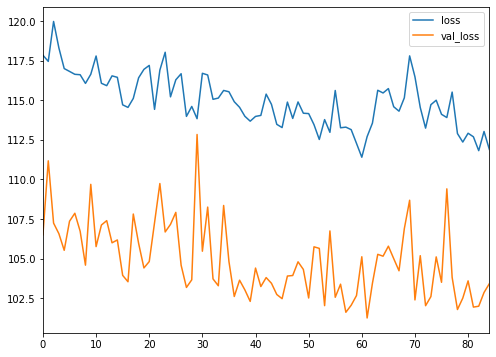

In [26]:
import pandas as pd
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [12]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(n, n))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [13]:
def gen_image(model, num_samples=10):
    # 形状是 100 * 784
    x_sample = np.random.rand(num_samples, img_rows * img_cols)
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(0, img_rows * img_cols):
        x_out = model.predict(x_sample)

        p = np.random.rand(num_samples)
        # 有可能这个input_sel是乱序的
        index = model.layers[-1].input_sel[i]
        
        x_sample[:, index] = (x_out[:, index] > p).astype(float)
        
    return x_sample

每个像素点的最终输出，是概率 $p(x_i|x_{1:i-1})$，如果大于随机数p则令，这个像素点为1，小于p则为0。

拿最后一个像素举例，现在已经输出了最后一个像素依赖于前面全部像素的条件概率，为1的概率是0.01，这很符合印象，即图片的右下角基本上可以确定是黑色，那么$p(x_i|x_{1:i-1})$ < p 几乎是一定的，即在没有意外的情况下，最后一个像素就是黑色。

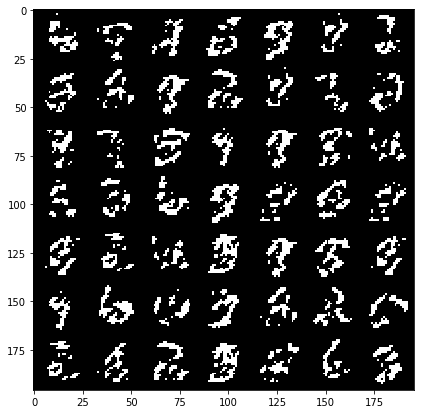

Elapsed:  81.2599139213562


In [27]:
import time
start = time.time()

tf.keras.backend.set_learning_phase(0)
x_sample = gen_image(model, num_samples=49)
# x_sample = gen_image(made, num_samples=100)
display_digits(x_sample, n=7)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)